In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import zscore

In [59]:
df = pd.read_csv("E:/NTI/Heart Failure/heart_failure_clinical_records_dataset.csv")

In [60]:
print("Data shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

Data shape: (299, 13)

Missing values:
 age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Duplicates: 0


In [61]:
# Remove outliers using Z-score (|Z| > 3)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
z_scores = np.abs(zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)]
print("\nData after outlier removal:", df.shape)


Data after outlier removal: (280, 13)


In [62]:
# Split features (X) and target (y)
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

In [63]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [64]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
# Get feature importances from Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

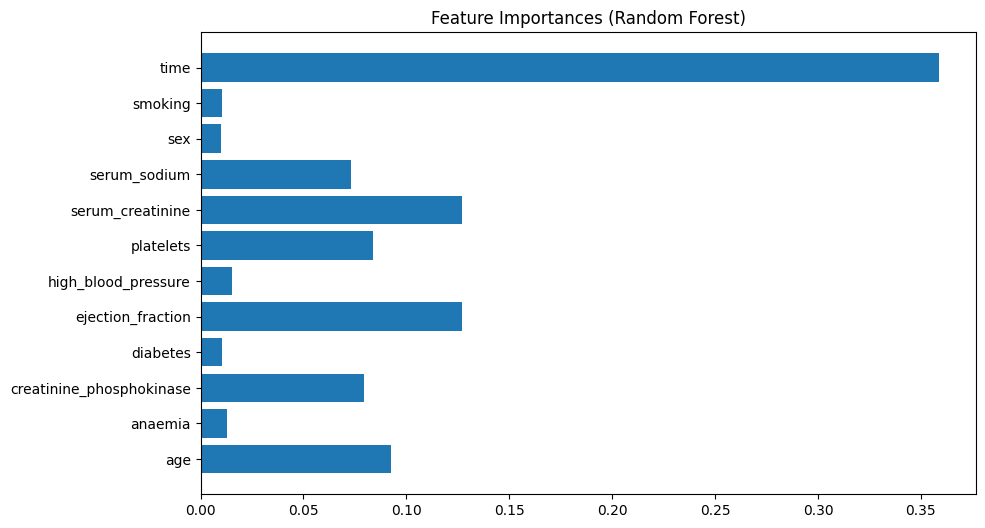

In [66]:
# Plot feature importances
importances = rf.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("Feature Importances (Random Forest)")
plt.show()

In [67]:
# Select top 5 most important features
top_features_idx = np.argsort(importances)[-5:]
X_train_selected = X_train_scaled[:, top_features_idx]
X_test_selected = X_test_scaled[:, top_features_idx]
print("\nTop 5 Features:", features[top_features_idx])


Top 5 Features: Index(['platelets', 'age', 'ejection_fraction', 'serum_creatinine', 'time'], dtype='object')


In [68]:
# 5. Model Evaluation Function
# ====================== #
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {model_name} Evaluation")
    print("✅ Accuracy:", round(acc * 100, 2), "%")
    print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} – Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} – ROC Curve")
    plt.legend()
    plt.show()


🔍 Random Forest (All Features) Evaluation
✅ Accuracy: 83.93 %

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89        39
           1       0.83      0.59      0.69        17

    accuracy                           0.84        56
   macro avg       0.84      0.77      0.79        56
weighted avg       0.84      0.84      0.83        56



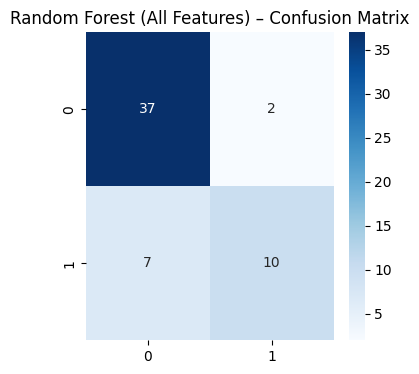

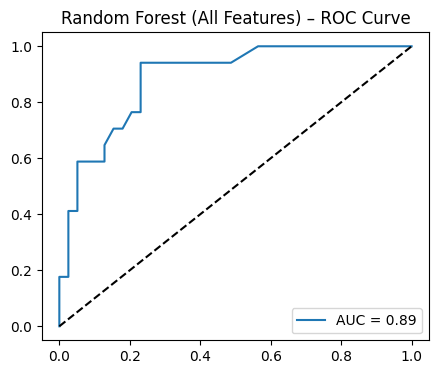

In [69]:
# 6. Model Training (Full Features)
# ====================== #
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)
evaluate_model(rf, X_test_scaled, y_test, "Random Forest (All Features)")


🔍 MLP (All Features) Evaluation
✅ Accuracy: 78.57 %

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85        39
           1       0.69      0.53      0.60        17

    accuracy                           0.79        56
   macro avg       0.75      0.71      0.73        56
weighted avg       0.78      0.79      0.78        56



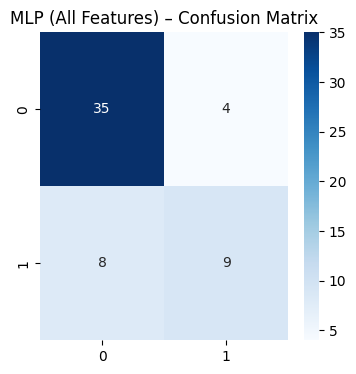

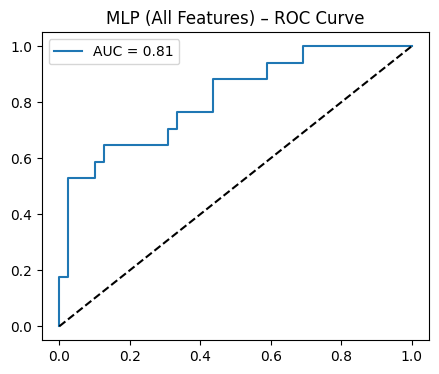

In [70]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu',
                    solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
evaluate_model(mlp, X_test_scaled, y_test, "MLP (All Features)")


🔍 Random Forest (Top 5 Features) Evaluation
✅ Accuracy: 80.36 %

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86        39
           1       0.71      0.59      0.65        17

    accuracy                           0.80        56
   macro avg       0.77      0.74      0.75        56
weighted avg       0.80      0.80      0.80        56



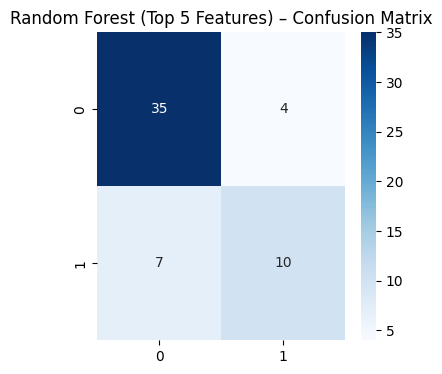

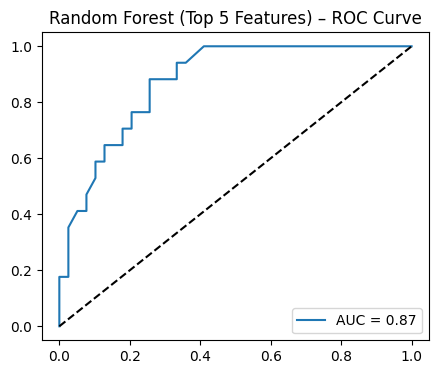

In [71]:
# 7. Model Training (Selected Features)
# ====================== #
# Random Forest (Selected Features)
rf_selected = RandomForestClassifier(n_estimators=200, random_state=42)
rf_selected.fit(X_train_selected, y_train)
evaluate_model(rf_selected, X_test_selected, y_test, "Random Forest (Top 5 Features)")



🔍 MLP (Top 5 Features) Evaluation
✅ Accuracy: 76.79 %

🧾 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        39
           1       0.61      0.65      0.63        17

    accuracy                           0.77        56
   macro avg       0.73      0.73      0.73        56
weighted avg       0.77      0.77      0.77        56



C:\Users\20106\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


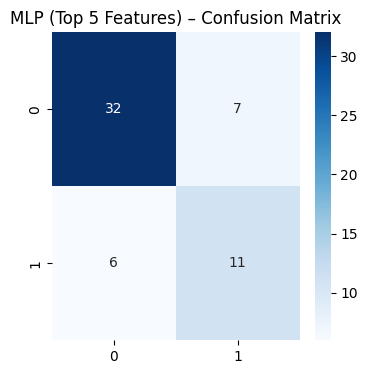

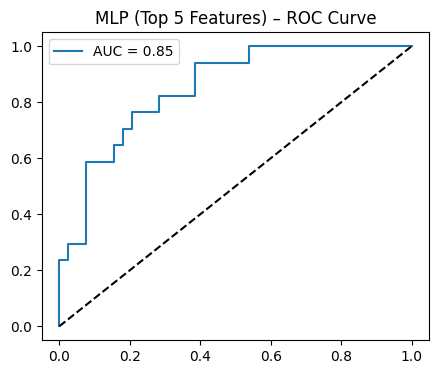

In [72]:
# MLP (Selected Features)
mlp_selected = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu',
                             solver='adam', max_iter=500, random_state=42)
mlp_selected.fit(X_train_selected, y_train)
evaluate_model(mlp_selected, X_test_selected, y_test, "MLP (Top 5 Features)")


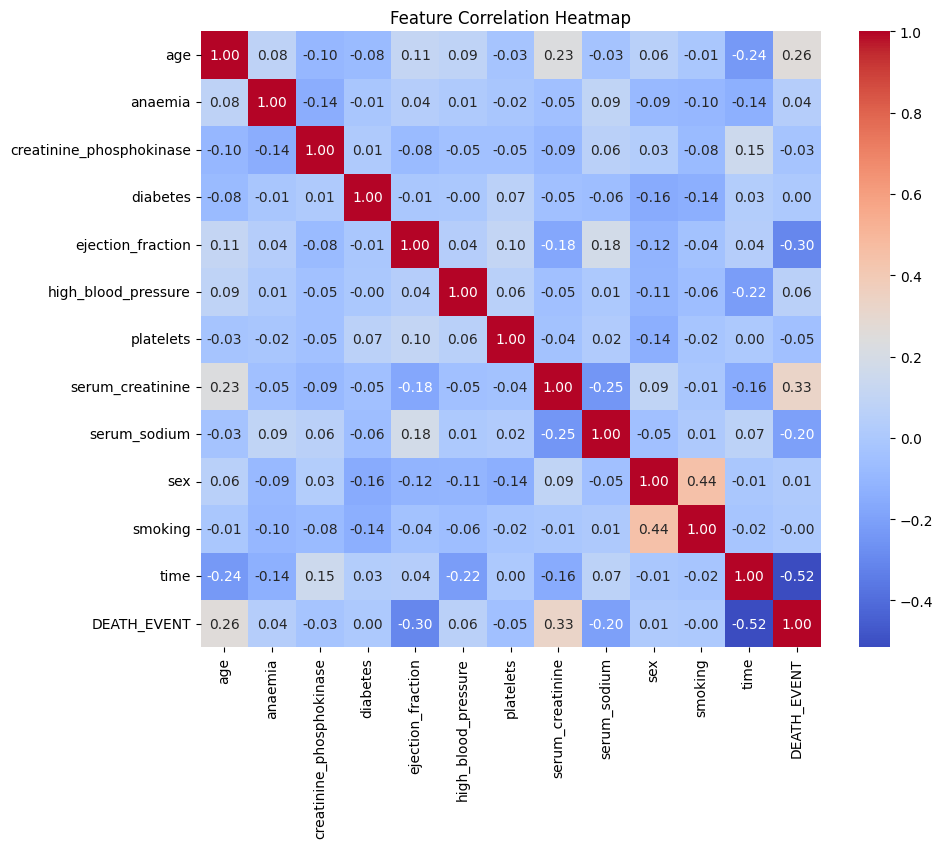

In [73]:
# 8. Correlation Analysis 
# ====================== #
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()